In [1]:
from glob import glob
import pandas as pd
import json
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation

def read_json(path):
    with open(path) as f:
        res = json.load(f)
    return res

sns.set(style='white',  font='sans-serif', font_scale=1.5)

In [2]:
import matplotlib
sns.__version__, matplotlib.__version__

('0.12.2', '3.7.5')

In [3]:
('0.11.2', '3.5.3')

('0.11.2', '3.5.3')

In [4]:
#pip install seaborn==0.11.2

In [5]:
dataset2name = {'chembl1871_ki': 'AR',
 'chembl218_ec50': 'CB1',
 'chembl244_ki': 'FX',
 'chembl236_ki': 'DOR',
 'chembl234_ki': 'D3R',
 'chembl219_ki': 'D4R',
 'chembl238_ki': 'DAT',
 'chembl4203_ki': 'CLK4',
 'chembl2047_ec50': 'FXR',
 'chembl4616_ec50': 'GHSR',
 'chembl2034_ki': 'GR',
 'chembl262_ki': 'GSK3',
 'chembl231_ki': 'HRH1',
 'chembl264_ki': 'HRH3',
 'chembl2835_ki': 'JAK1',
 'chembl2971_ki': 'JAK2',
 'chembl237_ec50': 'KOR (a)',
 'chembl237_ki': 'KOR (i)',
 'chembl233_ki': 'MOR',
 'chembl4792_ki': 'OX2R',
 'chembl239_ec50': r'PPAR$\alpha$',
 'chembl3979_ec50': r'PPAR$\gamma$',
 'chembl235_ec50': r'PPAR$\delta$',
 'chembl4005_ki': 'PIK3CA',
 'chembl2147_ki': 'PIM1',
 'chembl214_ki': '5-HT1A',
 'chembl228_ki': 'SERT',
 'chembl287_ki': 'SOR',
 'chembl204_ki': 'Thrombin',
 'chembl1862_ki': 'ABL1'}


df = pd.read_csv('../../../MoleculeACE/MoleculeACE/Data/results/MoleculeACE_results.csv')
df.dataset = df.dataset.apply(lambda x:x.lower())


In [6]:
dfd = pd.Series(dataset2name)
dfd.index = dfd.index.map(lambda x:x.lower())

In [7]:
df = df[df.descriptor.isin(['GRAPH', 'SMILES', 'ECFP', 'TOKENS'])]
#df = df[df.algorithm.isin(['AFP', 'CNN', 'GAT', 'GCN', 'LSTM', 'MLP', 'MPNN', 'SVM', 'Transformer'])]
df.algorithm.unique()

array(['AFP', 'CNN', 'GAT', 'GBM', 'GCN', 'KNN', 'LSTM', 'MLP', 'MPNN',
       'RF', 'SVM', 'Transformer'], dtype=object)

In [8]:
gs = glob('./benchmark_performance/mae_aca_opt_cliff/*/results.json')

ps = []
for path in gs:
    res = pd.Series(read_json(path))
    dataset = res.dataset.lower()
    algorithm = 'ACANet'
    descriptor = 'AT39'
    augmentation = None
    rmse = res.rmse         
    cliff_rmse = res.cliff_rmse  
    ps.append([dataset, algorithm, descriptor, augmentation, rmse, cliff_rmse])
dfg1 = pd.DataFrame(ps, columns = ['dataset', 'algorithm', 'descriptor', 'augmentation', 'rmse', 'cliff_rmse'])

In [9]:
dff = df._append(dfg1)
dff['name'] = dff.dataset.map(dataset2name)
dff = dff.reset_index(drop=True)
dff.rmse = dff.rmse.astype(float)
dff.cliff_rmse = dff.cliff_rmse.astype(float)

In [10]:
dff.algorithm.unique()

array(['AFP', 'CNN', 'GAT', 'GBM', 'GCN', 'KNN', 'LSTM', 'MLP', 'MPNN',
       'RF', 'SVM', 'Transformer', 'ACANet'], dtype=object)

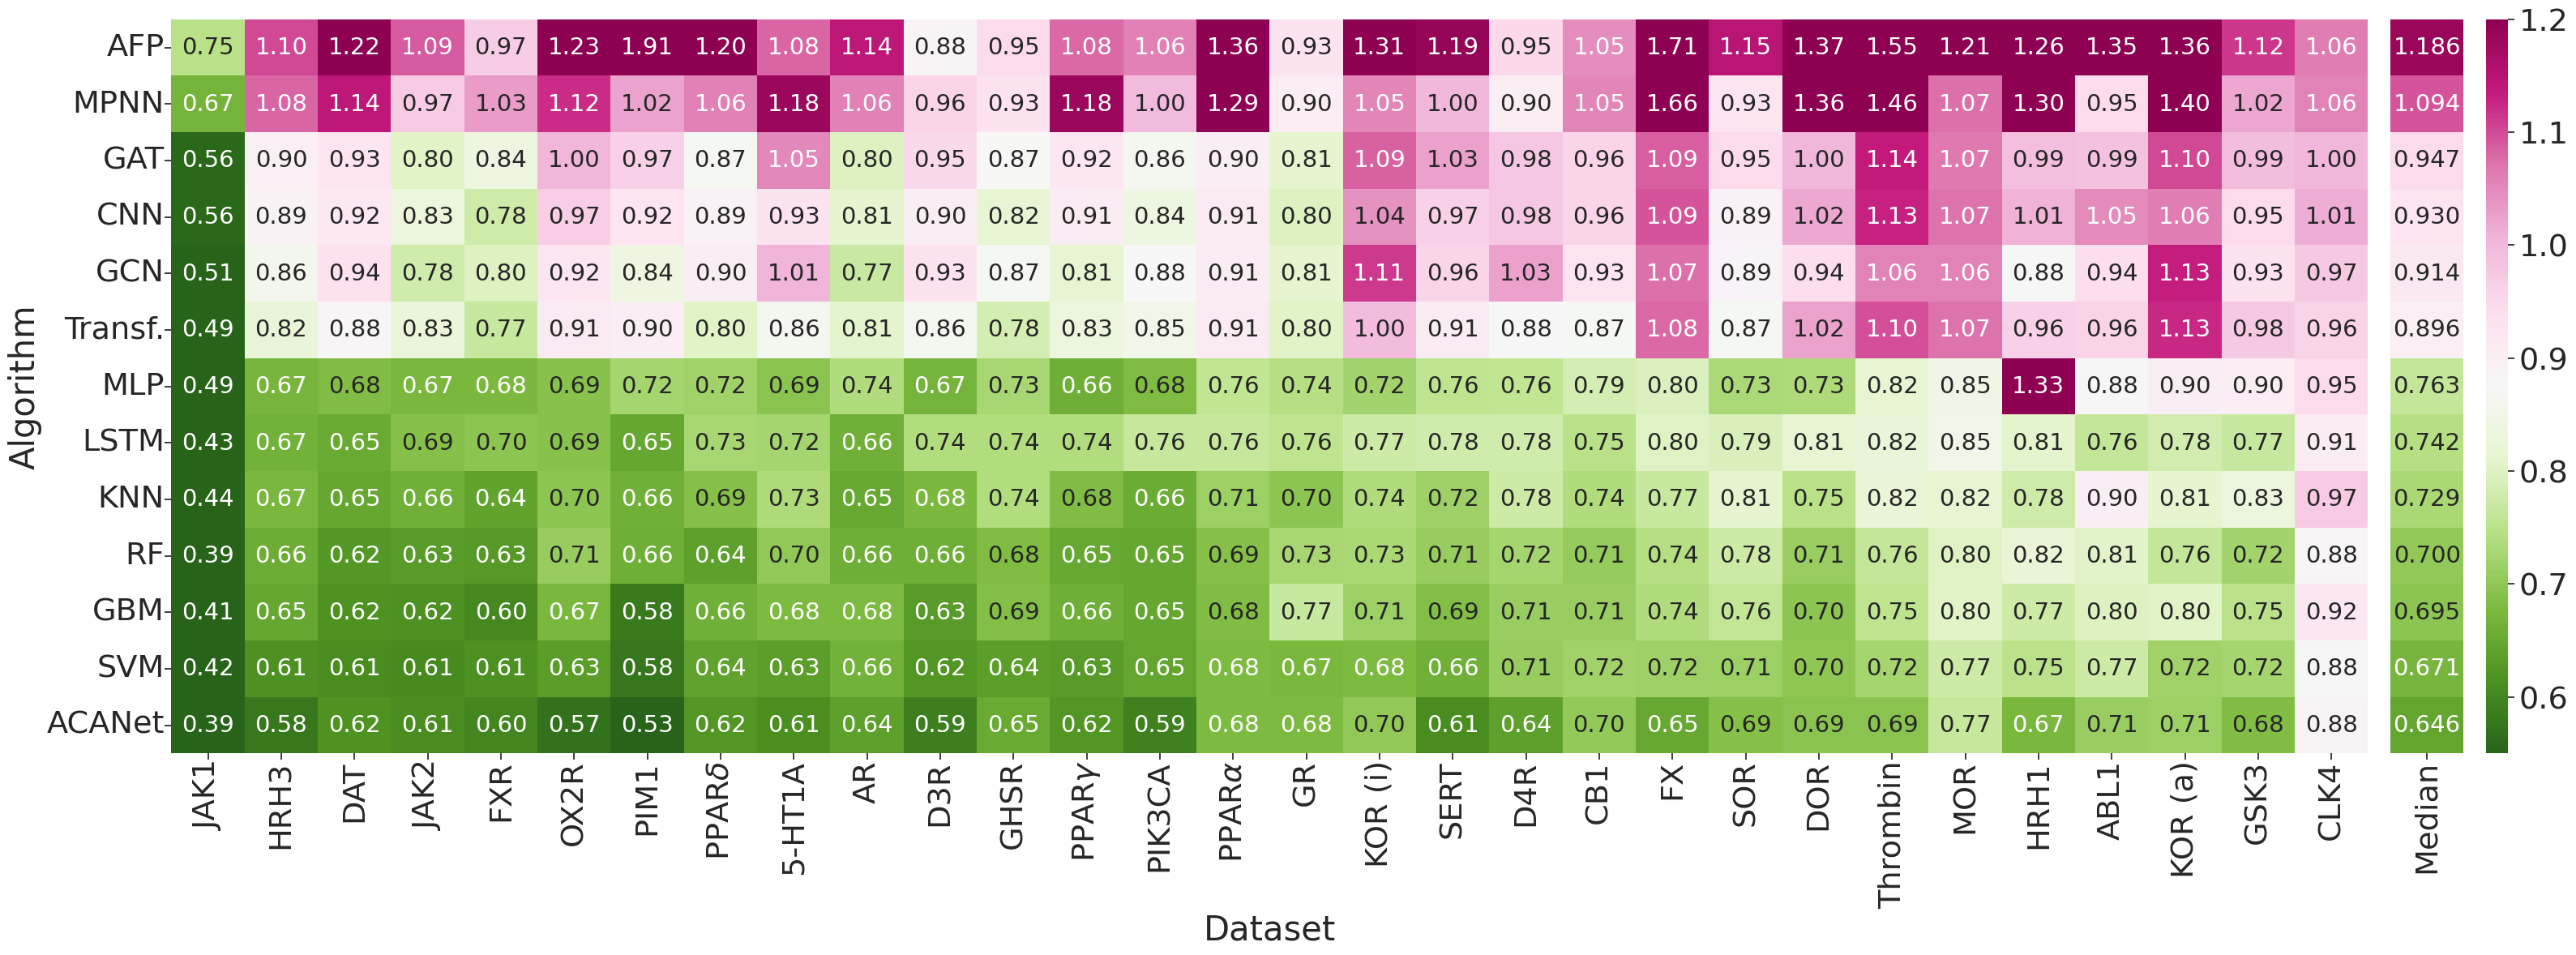

In [11]:
sns.set(style='white',  font='sans-serif', font_scale=2.5)

fig, axes= plt.subplots(ncols=3, figsize=(32,12), gridspec_kw={'width_ratios': [30, 1.,0.3]})

ax1, ax2, ax3 = axes

dffs = dff.groupby(['name','algorithm'])['rmse'].mean().unstack()
m = dffs.mean().sort_values(ascending=False).index.to_list()
d = dffs.T.median().sort_values().index.to_list()
dffs = dffs.loc[d][m]

fontsize = 21
dffs.columns = dffs.columns.map({'ACANet':'ACANet', 'SVM':'SVM', 'GBM':'GBM', 'RF':'RF', 
                                 'KNN':'KNN', 'MLP':'MLP', 'LSTM':'LSTM', 'Transformer':'Transf.',
                                 'CNN':'CNN', 'MPNN':'MPNN', 'AFP': 'AFP', 'GCN':'GCN', 'GAT':'GAT'})

h1 = sns.heatmap(dffs.T, cmap = 'PiYG_r', vmax=1.2, vmin = 0.55, ax=ax1, annot=True, fmt='.2f', cbar_ax = ax3, annot_kws ={'fontsize':fontsize},)

h2 = sns.heatmap(dffs.mean().to_frame(name='Median'), cmap = 'PiYG_r', vmin = 0.55, vmax=1.2, ax=ax2, annot=True, fmt='.3f', cbar = False, annot_kws ={'fontsize':fontsize},)


ax1.tick_params(left='off',  bottom='off', pad=.1,)
ax1.set_ylabel('Algorithm')
ax1.set_xlabel('Dataset')
ax2.set_ylabel('')
ax2.tick_params(axis='x',  bottom='off', pad=.1,)
ax2.tick_params(rotation=90)

ax2.set_yticklabels('')
#plt.suptitle('RMSE performance of the overall test set ($RMSE_{all}$)')

plt.tight_layout(pad=0.5)

fig.savefig("./benchmark_performance/overall_rmse_comparasions_heatmap.pdf",  bbox_inches='tight')
fig.savefig("./benchmark_performance/overall_rmse_comparasions_heatmap.svg",  bbox_inches='tight')

In [12]:
dffs[dffs.ACANet < dffs.SVM].shape, dffs[dffs.ACANet > dffs.SVM].shape

((23, 13), (7, 13))

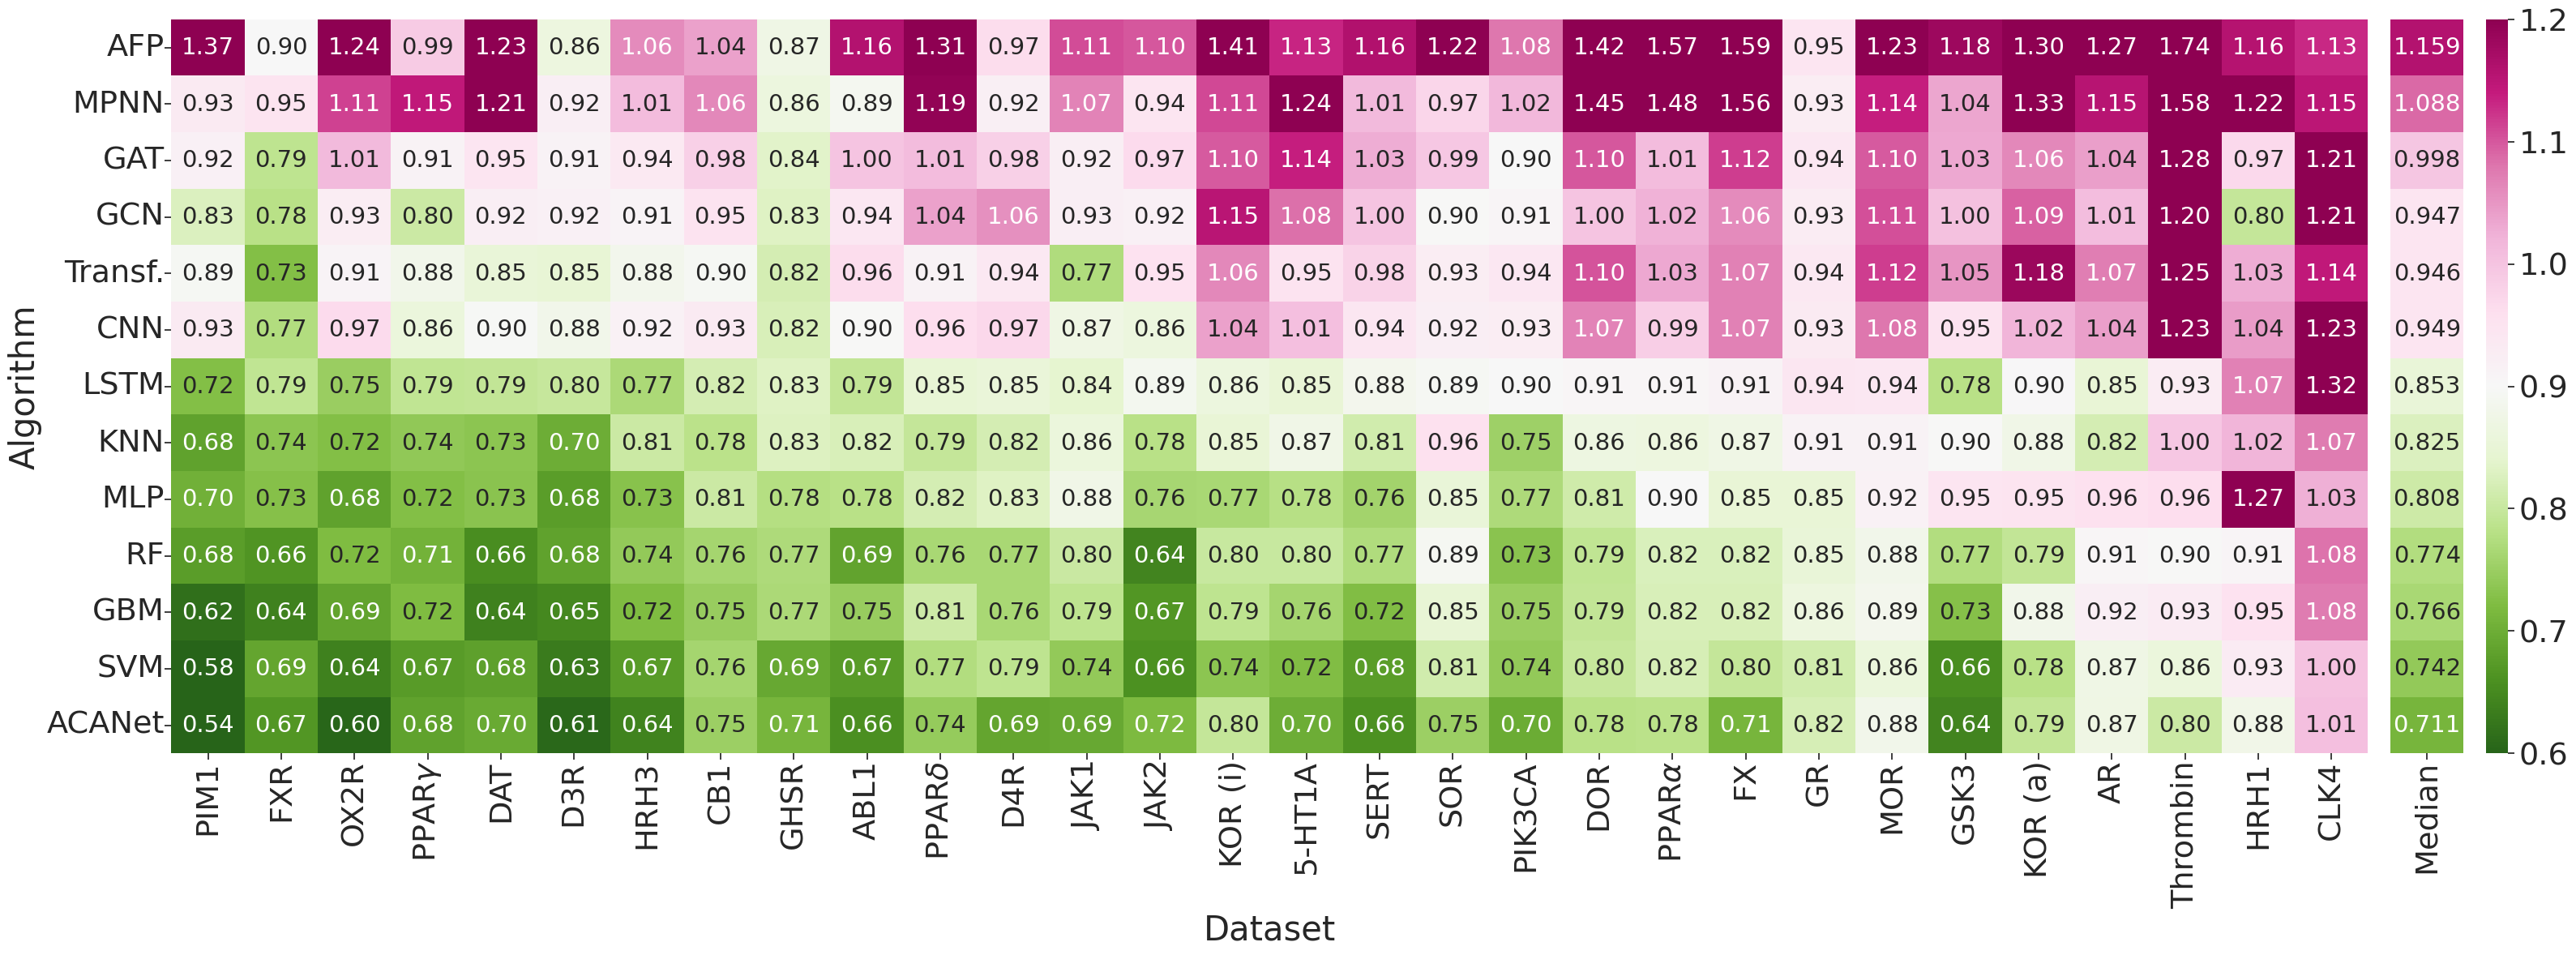

In [13]:
fig, axes= plt.subplots(ncols=3, figsize=(32,12), gridspec_kw={'width_ratios': [30, 1.,0.3]})

ax1, ax2, ax3 = axes

dffs = dff.groupby(['name','algorithm'])['cliff_rmse'].mean().unstack()
m = dffs.mean().sort_values(ascending=False).index.to_list()
d = dffs.T.median().sort_values().index.to_list()
dffs = dffs.loc[d][m]


dffs.columns = dffs.columns.map({'ACANet':'ACANet', 'SVM':'SVM', 'GBM':'GBM', 'RF':'RF', 
                                 'KNN':'KNN', 'MLP':'MLP', 'LSTM':'LSTM', 'Transformer':'Transf.',
                                 'CNN':'CNN', 'MPNN':'MPNN', 'AFP': 'AFP', 'GCN':'GCN', 'GAT':'GAT'})

h1 = sns.heatmap(dffs.T, cmap = 'PiYG_r', vmin = 0.6, vmax=1.2, ax=ax1, annot=True, fmt='.2f', cbar_ax = ax3, annot_kws ={'fontsize':fontsize},)

h2 = sns.heatmap(dffs.median().to_frame(name='Median'), cmap = 'PiYG_r', vmin = 0.6, vmax=1.2, ax=ax2, annot=True, fmt='.3f', cbar = False, annot_kws ={'fontsize':fontsize},)


ax1.tick_params(left='off',  bottom='off', pad=.1,)
ax2.tick_params(axis='x',  bottom='off', pad=.1,)

ax1.set_ylabel('Algorithm')
ax1.set_xlabel('Dataset')
ax2.set_ylabel('')

ax2.set_yticklabels('')
ax2.tick_params(rotation=90)


#plt.suptitle('RMSE performance of the cliff test set ($RMSE_{cliff}$)')
plt.tight_layout(pad=0.5)

fig.savefig("./benchmark_performance/cliff_rmse_comparasions_heatmap.pdf",  bbox_inches='tight')
fig.savefig("./benchmark_performance/cliff_rmse_comparasions_heatmap.svg",  bbox_inches='tight')

In [14]:
dffs[dffs.ACANet < dffs.SVM].shape, dffs[dffs.ACANet > dffs.SVM].shape

((21, 13), (9, 13))

In [15]:

dff.algorithm = dff.algorithm.map({'ACANet':'ACANet', 'SVM':'SVM', 'GBM':'GBM', 'RF':'RF', 
                                 'KNN':'KNN', 'MLP':'MLP', 'LSTM':'LSTM', 'Transformer':'Transf.',
                                 'CNN':'CNN', 'MPNN':'MPNN', 'AFP': 'AFP', 'GCN':'GCN', 'GAT':'GAT'})

/tmp/ipykernel_20740/2734680515.py:7: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=dff, x= 'algorithm', y='rmse', order=order, ax = ax, jitter=True, dodge=False, alpha = 0.6,


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

SVM v.s. ACANet: t-test paired samples, P_val=3.142e-03 stat=3.221e+00
GBM v.s. ACANet: t-test paired samples, P_val=1.224e-05 stat=5.262e+00
RF v.s. ACANet: t-test paired samples, P_val=6.760e-06 stat=5.476e+00
KNN v.s. ACANet: t-test paired samples, P_val=1.891e-08 stat=7.663e+00
MLP v.s. ACANet: t-test paired samples, P_val=6.265e-06 stat=5.504e+00


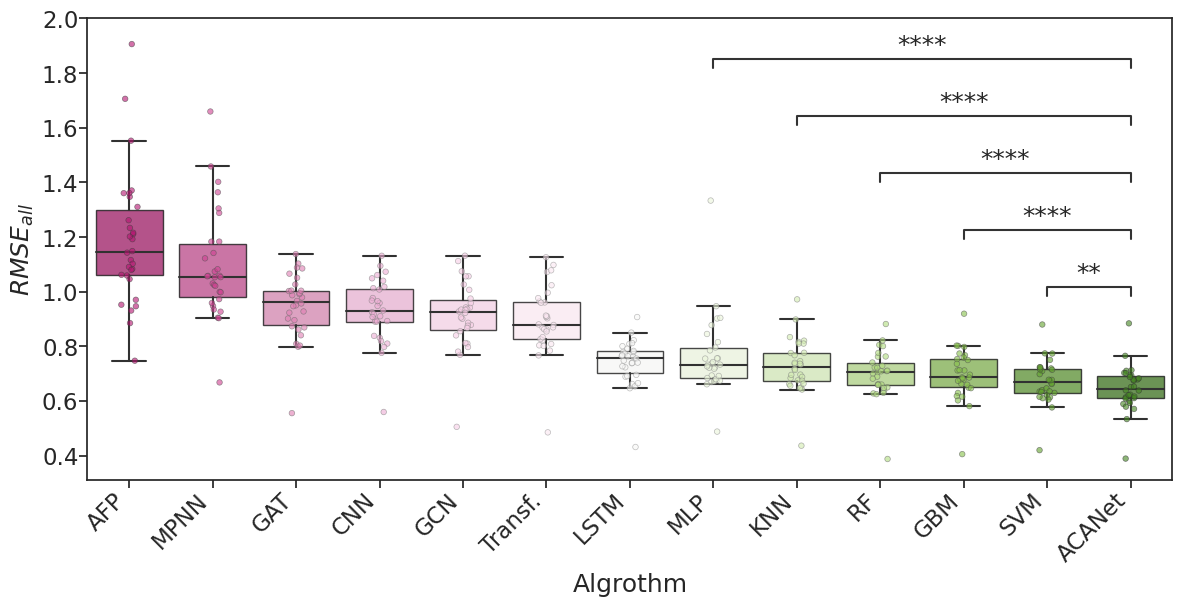

In [16]:
sns.set(style='white',  font='sans-serif', font_scale=1.5)

fig, ax= plt.subplots(figsize=(14,6))
palette = 'PiYG'
order = dff.groupby('algorithm').rmse.median().sort_values(ascending=False).index.to_list()
sns.boxplot(data = dff, x = 'algorithm', y = 'rmse', order = order,ax=ax, fliersize = 0, palette = palette, boxprops=dict(linewidth=1, edgecolor='k', alpha=0.8), )
sns.stripplot(data=dff, x= 'algorithm', y='rmse', order=order, ax = ax, jitter=True, dodge=False, alpha = 0.6,
              size=4, palette=palette,  linewidth=0.5,  edgecolor='gray')


box_pairs = [('ACANet', 'SVM'), ('ACANet', 'RF'), ('ACANet', 'GBM'), ('ACANet', 'MLP'), ('ACANet', 'KNN')]

add_stat_annotation(ax, data = dff, 
                    x = 'algorithm', y = 'rmse', 
                    order = order, plot='boxplot',
                    box_pairs=box_pairs,
                    test='t-test_paired', 
                    comparisons_correction = None,
                    text_format='star', 
                    loc='inside', verbose=2)


plt.xticks(rotation=45, ha='right')
ax.tick_params(left='off',  bottom='off', pad=.5,)
ax.set_ylabel('$RMSE_{all}$')
ax.set_xlabel('Algrothm')


fig.savefig("./benchmark_performance/overall_rmse_comparasions_box.pdf",  bbox_inches='tight')
fig.savefig("./benchmark_performance/overall_rmse_comparasions_box.svg",  bbox_inches='tight')

/tmp/ipykernel_20740/581037054.py:6: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=dff, x= 'algorithm', y='cliff_rmse', order=order, ax = ax, jitter=True, dodge=False, alpha = 0.6,


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

SVM v.s. ACANet: t-test paired samples, P_val=1.384e-01 stat=1.524e+00
GBM v.s. ACANet: t-test paired samples, P_val=1.619e-03 stat=3.477e+00
RF v.s. ACANet: t-test paired samples, P_val=1.200e-03 stat=3.591e+00
MLP v.s. ACANet: t-test paired samples, P_val=6.833e-06 stat=5.472e+00
KNN v.s. ACANet: t-test paired samples, P_val=8.664e-07 stat=6.223e+00


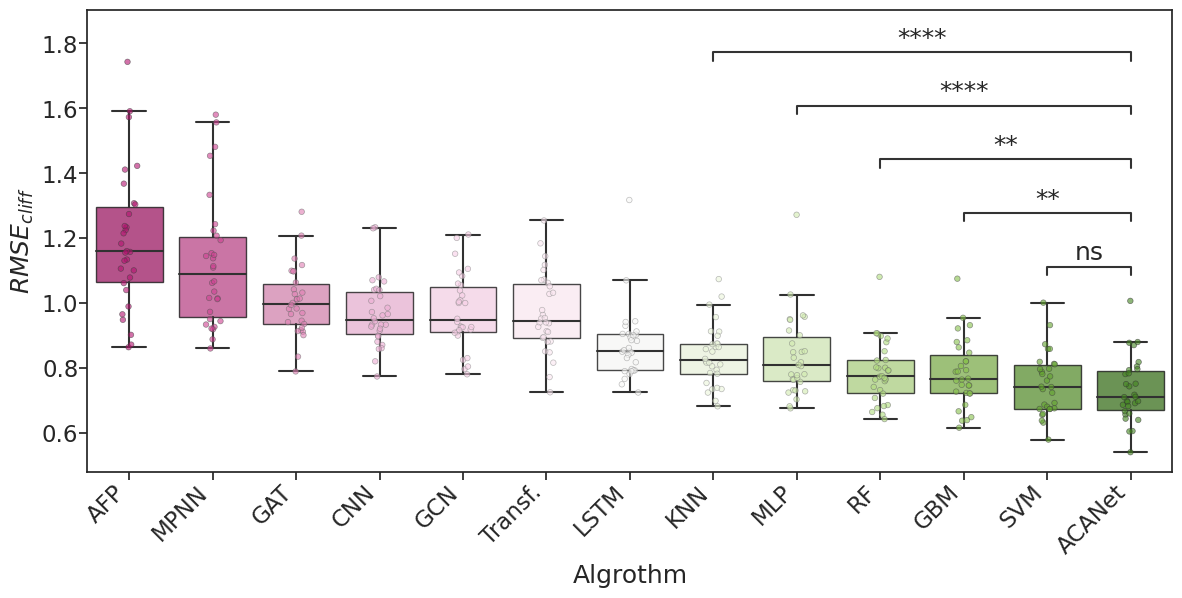

In [17]:
fig, ax= plt.subplots(figsize=(14,6))

order = dff.groupby('algorithm').cliff_rmse.median().sort_values(ascending=False).index.to_list()

sns.boxplot(data = dff, x = 'algorithm', y = 'cliff_rmse', order = order,ax=ax, fliersize = 0, palette = palette, boxprops=dict(linewidth=1, edgecolor='k', alpha=0.8), )
sns.stripplot(data=dff, x= 'algorithm', y='cliff_rmse', order=order, ax = ax, jitter=True, dodge=False, alpha = 0.6,
              size=4, palette=palette,  linewidth=0.5,  edgecolor='gray')


box_pairs = [('ACANet', 'SVM'), ('ACANet', 'RF'), ('ACANet', 'GBM'), ('ACANet', 'MLP'), ('ACANet', 'KNN')]

add_stat_annotation(ax, data = dff, x = 'algorithm', y = 'cliff_rmse', order = order,
                     plot='boxplot',
                    box_pairs=box_pairs,
                    test='t-test_paired', 
                    comparisons_correction = None,
                    text_format='star', 
                    loc='inside', verbose=2)

plt.xticks(rotation=45, ha='right')
ax.set_ylabel('$RMSE_{cliff}$')
ax.tick_params(left='off',  bottom='off', pad=.5,)
ax.set_xlabel('Algrothm')

fig.savefig("./benchmark_performance/cliff_rmse_comparasions_box.pdf",  bbox_inches='tight')
fig.savefig("./benchmark_performance/cliff_rmse_comparasions_box.svg",  bbox_inches='tight')

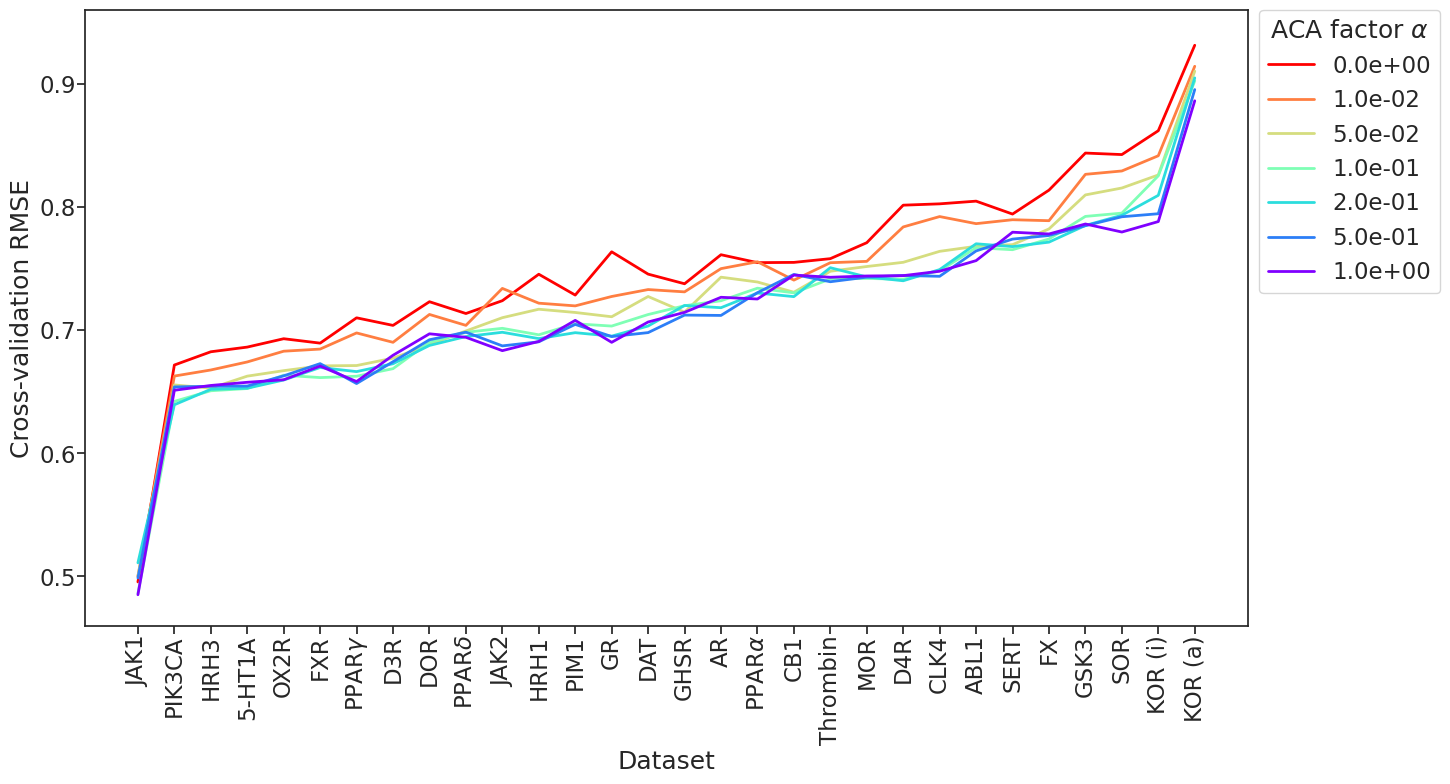

In [18]:
gs = glob('./benchmark_performance/mae_aca_opt_cliff/*/alpha_performance.csv')

ps = []
for path in gs:
    dataset = path.split('/')[-2]
    res = pd.read_csv(path, index_col=0)
    res['dataset'] = dataset
    ps.append(res)
    
dfp = pd.concat(ps)


dfp1 = pd.pivot_table(dfp, values='rmse', index='dataset', columns='alpha')
fig, ax = plt.subplots(figsize=(15, 8))
idx = dfp1.mean(axis=1).sort_values(ascending=True).index.tolist()
dfp1.columns = dfp1.columns.map(lambda x:'%.1e' % x)
dfp1 = dfp1.loc[idx]
dfp1.index = dfp1.index.map(lambda x:x.lower()).map(dataset2name)

dfp1.plot(ax= ax, colormap ='rainbow_r', lw = 2,)

ax.tick_params(left='off',  bottom='off', pad=.5,)

handles, labels = ax.get_legend_handles_labels()

l = plt.legend(handles, labels, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., title=r'ACA factor $\alpha$')

ax.set_ylabel('Cross-validation RMSE')
ax.set_xlabel('Dataset')


ax.set_xticks(range(len(dfp1)))

ax.set_xticklabels(dfp1.index, rotation=90, )

ax.set_ylim(0.46, 0.96)
fig.savefig("./benchmark_performance/ACA_alpha_effect.pdf",  bbox_inches='tight')
fig.savefig("./benchmark_performance/ACA_alpha_effect.svg",  bbox_inches='tight')

In [19]:
dfp1 = pd.pivot_table(dfp, values='rmse', index='dataset', columns='alpha')
dfp1_err = pd.pivot_table(dfp, values='rmse_err', index='dataset', columns='alpha')

dfp1['dataset_name'] = dfp1.index.map(lambda x:x.lower()).map(dataset2name)

wo_aca = dfp1[dfp1.columns[:1]].min(axis=1).to_frame('without_aca')
wo_aca_err = dfp1_err[dfp1.columns[:1]].min(axis=1).to_frame('without_aca_err')

wi_aca = dfp1[dfp1.columns[1:-1]].min(axis=1).to_frame('with_aca')
errs = []
for i, c in dfp1[dfp1.columns[1:-1]].idxmin(axis=1).items():
    errs.append(dfp1_err.loc[i][c])

wi_aca['with_aca_err'] = errs

data = dfp1[['dataset_name']].join(wo_aca).join(wo_aca_err).join(wi_aca)
boost = (data.without_aca - data.with_aca) / data.without_aca * 100
data['improvement'] = '↓ ' + boost.apply(lambda x: '%.2f' % x) + '%'
l2 = r'With AC-awareness ($\mathcal{L}_{mae} + \mathcal{L}_{tsm}$)'
l1 = r'Without AC-awareness ($\mathcal{L}_{mae}$)'

data[l1] = data.without_aca.apply(lambda x: '%.3f' % x) + ' ± ' + data.without_aca_err.apply(lambda x: '%.3f' % x)
data[l2] = data.with_aca.apply(lambda x: '%.3f' % x) + ' ± ' + data.with_aca_err.apply(lambda x: '%.3f' % x)

data[['dataset_name',l1,l2, 'improvement']].to_excel('boost_on_mae.xlsx')

In [20]:
data.without_aca.mean().round(3),data.without_aca.std().round(3)

(0.75, 0.077)

In [21]:
data.with_aca.mean().round(3),data.with_aca.std().round(3)

(0.71, 0.068)

In [22]:
boost.mean().round(2), boost.std()

(5.33, 1.8671573940867006)

In [23]:
(0.757 - 0.705) / 0.757

0.06869220607661829

[Text(0, 0, 'JAK1'),
 Text(1, 0, 'PIK3CA'),
 Text(2, 0, '5-HT1A'),
 Text(3, 0, 'HRH3'),
 Text(4, 0, 'PPAR$\\gamma$'),
 Text(5, 0, 'JAK2'),
 Text(6, 0, 'OX2R'),
 Text(7, 0, 'D3R'),
 Text(8, 0, 'PPAR$\\delta$'),
 Text(9, 0, 'FXR'),
 Text(10, 0, 'DOR'),
 Text(11, 0, 'GR'),
 Text(12, 0, 'DAT'),
 Text(13, 0, 'HRH1'),
 Text(14, 0, 'AR'),
 Text(15, 0, 'PIM1'),
 Text(16, 0, 'GHSR'),
 Text(17, 0, 'PPAR$\\alpha$'),
 Text(18, 0, 'CB1'),
 Text(19, 0, 'MOR'),
 Text(20, 0, 'Thrombin'),
 Text(21, 0, 'D4R'),
 Text(22, 0, 'CLK4'),
 Text(23, 0, 'ABL1'),
 Text(24, 0, 'FX'),
 Text(25, 0, 'SERT'),
 Text(26, 0, 'SOR'),
 Text(27, 0, 'GSK3'),
 Text(28, 0, 'KOR (i)'),
 Text(29, 0, 'KOR (a)')]

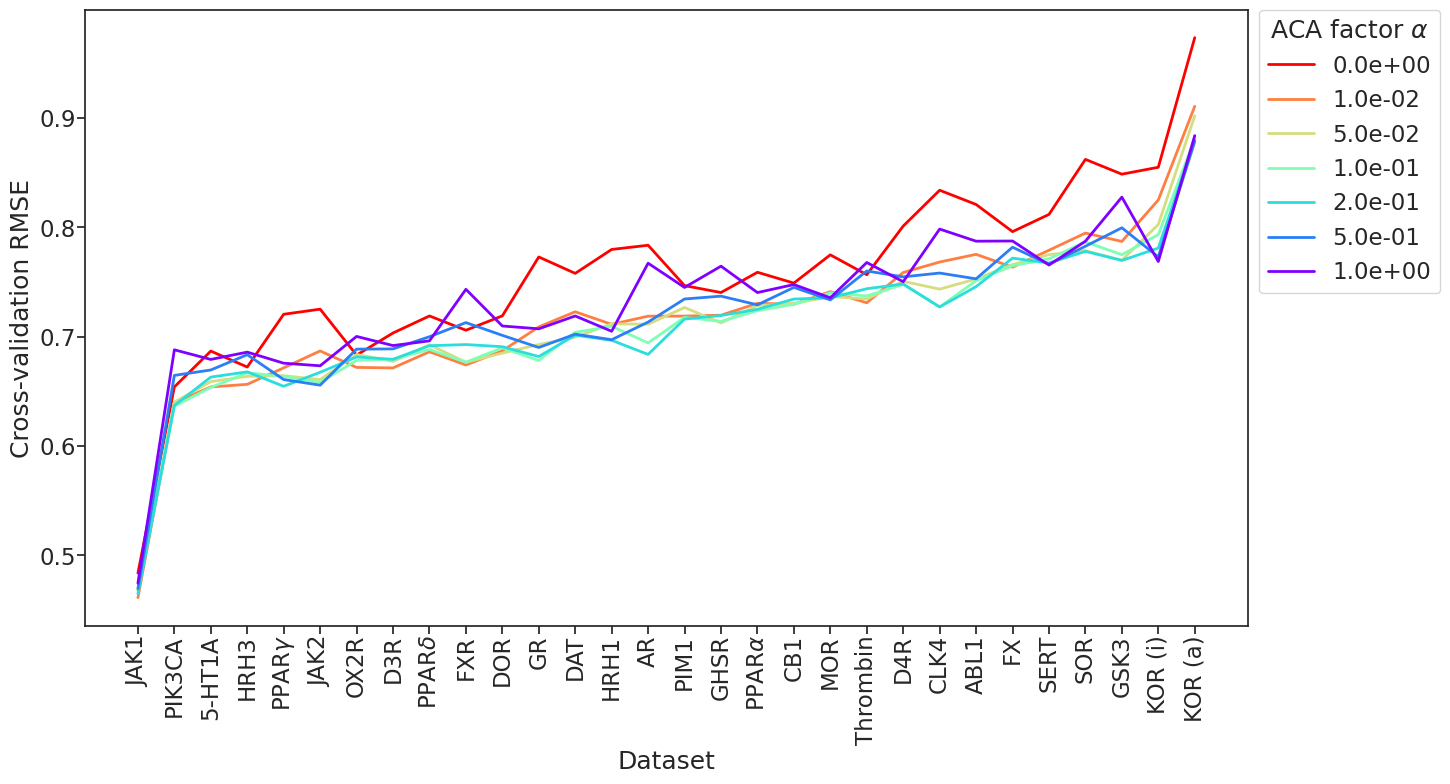

In [24]:
gs = glob('./benchmark_performance/mse_aca_opt_cliff/*/alpha_performance.csv')

ps = []
for path in gs:
    dataset = path.split('/')[-2]
    res = pd.read_csv(path, index_col=0)
    res['dataset'] = dataset
    ps.append(res)
    
dfp = pd.concat(ps)


dfp1 = pd.pivot_table(dfp, values='rmse', index='dataset', columns='alpha')
fig, ax = plt.subplots(figsize=(15, 8))
idx = dfp1.mean(axis=1).sort_values(ascending=True).index.tolist()
dfp1.columns = dfp1.columns.map(lambda x:'%.1e' % x)
dfp1 = dfp1.loc[idx]
dfp1.index = dfp1.index.map(lambda x:x.lower()).map(dataset2name)

dfp1.plot(ax= ax, colormap ='rainbow_r', lw = 2,)

ax.tick_params(left='off',  bottom='off', pad=.5,)

handles, labels = ax.get_legend_handles_labels()

l = plt.legend(handles, labels, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., title=r'ACA factor $\alpha$')

ax.set_ylabel('Cross-validation RMSE')
ax.set_xlabel('Dataset')


ax.set_xticks(range(len(dfp1)))

ax.set_xticklabels(dfp1.index, rotation=90, )

# ax.set_ylim(0.46, 0.96)
# fig.savefig("./benchmark_performance/ACA_alpha_effect.pdf",  bbox_inches='tight')
# fig.savefig("./benchmark_performance/ACA_alpha_effect.svg",  bbox_inches='tight')

In [25]:
dfp1 = pd.pivot_table(dfp, values='rmse', index='dataset', columns='alpha')
dfp1_err = pd.pivot_table(dfp, values='rmse_err', index='dataset', columns='alpha')

dfp1['dataset_name'] = dfp1.index.map(lambda x:x.lower()).map(dataset2name)

wo_aca = dfp1[dfp1.columns[:1]].min(axis=1).to_frame('without_aca')
wo_aca_err = dfp1_err[dfp1.columns[:1]].min(axis=1).to_frame('without_aca_err')

wi_aca = dfp1[dfp1.columns[1:-1]].min(axis=1).to_frame('with_aca')
errs = []
for i, c in dfp1[dfp1.columns[1:-1]].idxmin(axis=1).items():
    errs.append(dfp1_err.loc[i][c])

wi_aca['with_aca_err'] = errs

data = dfp1[['dataset_name']].join(wo_aca).join(wo_aca_err).join(wi_aca)
boost = (data.without_aca - data.with_aca) / data.without_aca * 100
data['improvement'] = '↓ ' + boost.apply(lambda x: '%.2f' % x) + '%'

data = dfp1[['dataset_name']].join(wo_aca).join(wo_aca_err).join(wi_aca)
boost = (data.without_aca - data.with_aca) / data.without_aca * 100
data['improvement'] = '↓ ' + boost.apply(lambda x: '%.2f' % x) + '%'
l2 = r'With AC-awareness ($\mathcal{L}_{mse} + \mathcal{L}_{tsm}$)'
l1 = r'Without AC-awareness ($\mathcal{L}_{mse}$)'

data[l1] = data.without_aca.apply(lambda x: '%.3f' % x) + ' ± ' + data.without_aca_err.apply(lambda x: '%.3f' % x)
data[l2] = data.with_aca.apply(lambda x: '%.3f' % x) + ' ± ' + data.with_aca_err.apply(lambda x: '%.3f' % x)

data[['dataset_name',l1,l2, 'improvement']].to_excel('boost_on_mse.xlsx')

In [26]:
data[['dataset_name',l1,l2, 'improvement']]

,dataset_name,Without AC-awareness ($\mathcal{L}_{mse}$),With AC-awareness ($\mathcal{L}_{mse} + \mathcal{L}_{tsm}$),improvement
dataset,,,,
CHEMBL1862_Ki,ABL1,0.821 ± 0.006,0.746 ± 0.004,↓ 9.16%
CHEMBL1871_Ki,AR,0.784 ± 0.013,0.684 ± 0.009,↓ 12.75%
CHEMBL2034_Ki,GR,0.773 ± 0.004,0.678 ± 0.008,↓ 12.25%
CHEMBL2047_EC50,FXR,0.706 ± 0.007,0.674 ± 0.004,↓ 4.50%
CHEMBL204_Ki,Thrombin,0.757 ± 0.006,0.731 ± 0.005,↓ 3.40%
CHEMBL2147_Ki,PIM1,0.747 ± 0.004,0.716 ± 0.004,↓ 4.10%
CHEMBL214_Ki,5-HT1A,0.687 ± 0.004,0.654 ± 0.005,↓ 4.84%
CHEMBL218_EC50,CB1,0.749 ± 0.014,0.730 ± 0.013,↓ 2.58%
CHEMBL219_Ki,D4R,0.801 ± 0.008,0.748 ± 0.006,↓ 6.67%
